In [1]:
##################################
#The notebook needed
%matplotlib inline 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from IPython.display import Math
import warnings
warnings.filterwarnings("ignore")

##################################
# The gral needed needed
import itertools
import numpy as np
from scipy.special import erf
from scipy import optimize
import math
import random
import importlib
##################################
# IO
import os
import sys
import scipy.io as sio
import re
from os import listdir
from os.path import isfile, join
import pickle

##################################
# Plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import matplotlib as mpl
mpl.style.use('classic')

##################################

# add code path 
ScriptsDir=os.path.abspath(os.path.join(os.path.dirname( "__file__" ), '../..', 'Scripts/'))
sys.path.append(ScriptsDir)

# path 2 data
DataDir=os.path.abspath(os.path.join(os.path.dirname( "__file__" ), 'DansData/'))


# make output path 
outputDir=os.path.abspath(os.path.join(os.path.dirname( "__file__" ),  'Output'))
if not os.path.exists(outputDir):
    os.makedirs(outputDir)




In [2]:


class DansData(object):
    """
       n_e is the number of E populations
       n_i is the number of I populations
       Nvec is a list with the number of elements
       in each population

    """

    def __init__(self, DataDir_):
        
        
        self.DataDir=DataDir_ +"/"
        self.getNumberofNeuronsandContrast()

    def getAllData(self,keyword=None):
        if not keyword:
            if 'New' in self.DataDir: # we are in the new data set
                keyword='ctrcutoff_11'
            else: # we are in the old one
                keyword='mat'
        onlyfiles = [f for f in listdir(self.DataDir) if isfile(join(self.DataDir, f)) and keyword in f and not f.startswith('.') and not 'non' in f]
        onlyfiles.sort()
        return onlyfiles



    def getNumberofNeuronsandContrast(self):
        onlyfiles=self.getAllData()
        self.n=len(onlyfiles);
        print(onlyfiles)
        Nvec=[];
        for k in range(self.n):
            aux=sio.loadmat(self.DataDir+onlyfiles[k],struct_as_record=True,squeeze_me=True)
            Nvec.append(aux["snorm"].shape[0])
            cvec=aux["modal_ucontrast"]
            
        self.Nvec=Nvec
        self.cvec=cvec

        
        
    def plotfiringRatesDistributionsVsContrastData(self,size_index,nameoutwithpath):
        onlyfiles=self.getAllData()
        lof=len(onlyfiles);
        ndots=len(self.cvec)
        mycolor=['black','orange','xkcd:salmon']
        fig, axs = plt.subplots(self.n,ndots, figsize=(15, 7), facecolor='w', edgecolor='k',sharex='col', sharey='row')
        fig.subplots_adjust(hspace = .1, wspace=0)
        titles=['E','SST','VIP']
        nbins=[100,30,20]
        for i in range(self.n):
            for c in np.arange(0,ndots,1):
                aux=sio.loadmat(self.DataDir+onlyfiles[i],struct_as_record=True,squeeze_me=True)
                axs[i,c].hist(aux["snorm"][:,size_index,c],density=True,bins=nbins[i],color=mycolor[i],edgecolor='None',alpha = 0.6);
                axs[i,0].set_title(titles[i])
                axs[self.n-1,c].set_xlabel("Response")
                axs[i,c].set_ylim([0, 10])
                axs[i,c].set_xlim([0, 1])
        fig.tight_layout()



# Make instance

In [3]:
MyData=DansData(DataDir)

# Each file is an interneuron with a field snorm with dimensions #Neurons, Size, Contrast
Allsizes=np.array([5,8,13,22,36]);
contrast=np.array([0, 6,12,25, 50,100])
ctrcutoff=11 # This is the receptive field alignement, data really depends on this
#We are interested only in some sizes



['New_Normalized_pyr_l23_All_Responses_Vs_contrast_by_size_running-runcutoff_10-ctrcutoff_11.mat', 'New_Normalized_sst_All_Responses_Vs_contrast_by_size_running-runcutoff_10-ctrcutoff_11.mat', 'New_Normalized_vip_All_Responses_Vs_contrast_by_size_running-runcutoff_10-ctrcutoff_11.mat']


# Choose the sizes to analyze 

Depending on what we decide with the experimentalists it will be either 8 or 13

In [4]:
AnalyzeSizes=np.array([13])

# Plot rate distirbutions as a function of contrast 

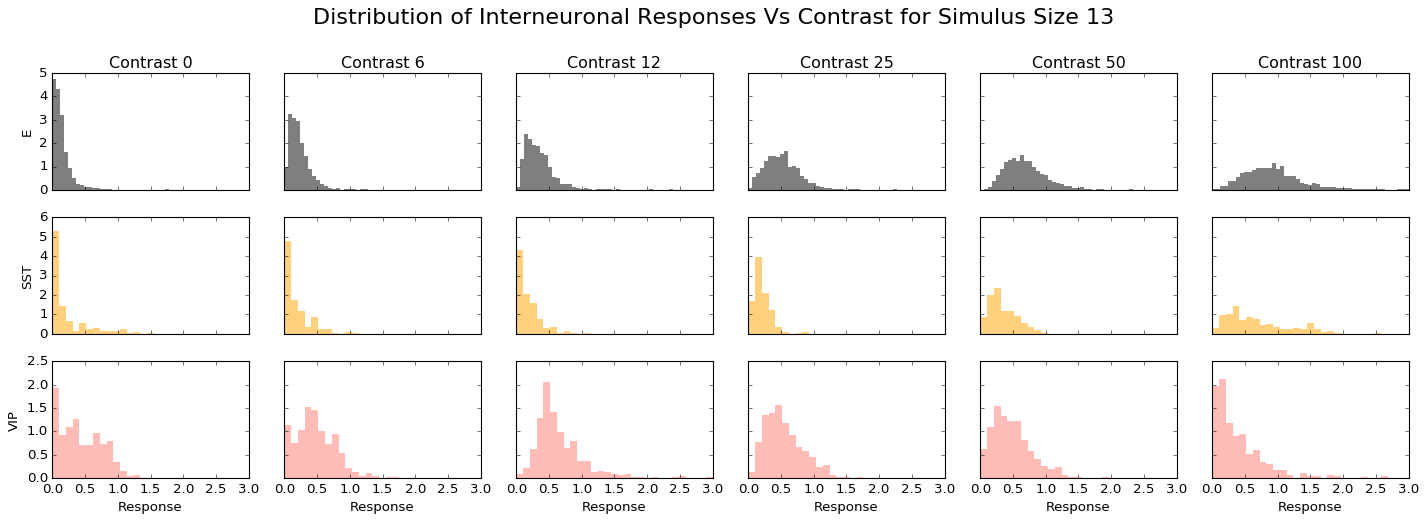

In [5]:
cm = plt.cm.get_cmap('magma')
plt.rcParams.update({'font.size': 12})

#We look for all files that have that ctrcutoff
keyword='ctrcutoff_'+str(ctrcutoff)
onlyfiles=MyData.getAllData(keyword)


# Plot distributions
for ii in range(len(AnalyzeSizes)):
    ndots=len(MyData.cvec)
    mycolor=['black','orange','xkcd:salmon']
    fig, axs = plt.subplots(MyData.n,ndots, figsize=(18, 7), dpi= 80,facecolor='w', edgecolor='k',sharex='col',sharey='row')
    fig.subplots_adjust(hspace = 0.2, wspace=0.2)
    titles=['E','SST','VIP']
    nbins=[50,30,30]

    for i in range(MyData.n):
        rawdata=sio.loadmat(MyData.DataDir+onlyfiles[i],struct_as_record=True,squeeze_me=True)


        for c in np.arange(0,ndots,1):
            size_index,=np.where(Allsizes==AnalyzeSizes[ii])
            
            rawdata_thisSize_thisContrast=rawdata["snorm"][:,size_index,c]

            axs[i,c].hist(rawdata_thisSize_thisContrast[rawdata_thisSize_thisContrast>0],density=True,bins=np.linspace(0,3,nbins[i]),color=mycolor[i],edgecolor='None',alpha = 0.5);
            axs[i,0].set_ylabel(titles[i])
            axs[MyData.n-1,c].set_xlabel("Response")
            axs[0,c].set_title("Contrast " + str(contrast[c]))
            axs[i,c].set_xlim([0, 3])

    fig.suptitle('Distribution of Interneuronal Responses Vs Contrast for Simulus Size '+str(AnalyzeSizes[ii]), fontsize=20)
    fig.tight_layout(rect=[0, 0.05, 1, 0.92])

    fig.savefig(outputDir+"/FiringRateDistributions-Sizes_"+str(AnalyzeSizes[ii])+"-ctrcutoff_"+str(ctrcutoff)+".pdf", bbox_inches='tight')



# Compute mean and variance for each neuronal type

In [6]:

distStd=np.zeros((3,len(AnalyzeSizes),6))
distmean=np.zeros((3,len(AnalyzeSizes),6))

for ii in range(len(AnalyzeSizes)):
    onlyfiles=MyData.getAllData()
    size_index,=np.where(Allsizes==AnalyzeSizes[ii])
    for i in range(MyData.n):
        for c in np.arange(0,ndots,1):
            rawdata=sio.loadmat(MyData.DataDir+onlyfiles[i],struct_as_record=True,squeeze_me=True)
            rawdata_thisSize_thisContrast=rawdata["snorm"][:,size_index,c]
            
            distStd[i,ii,c]=np.nanstd(rawdata_thisSize_thisContrast[rawdata_thisSize_thisContrast>0])
            distmean[i,ii,c]=np.nanmean(rawdata_thisSize_thisContrast[rawdata_thisSize_thisContrast>0])

            


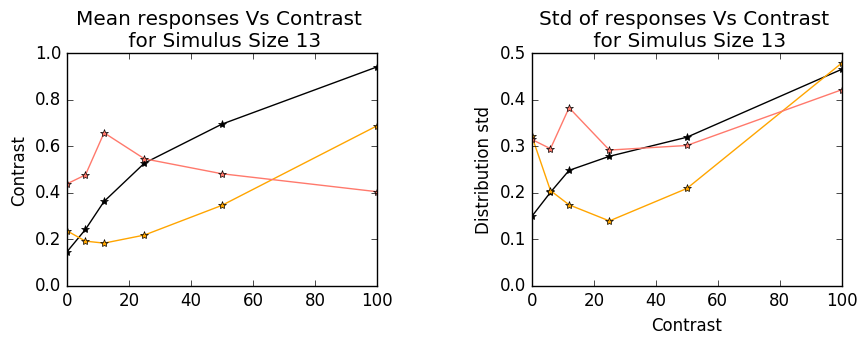

In [7]:
mycolor=['black','xkcd:turquoise','orange','xkcd:salmon']


for ii in range(len(AnalyzeSizes)):
    fig = plt.figure(figsize=(10, 3), dpi= 100, facecolor='w', edgecolor='k')
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    fig.subplots_adjust(hspace=2, wspace=0.5)
    
    ax1.set_facecolor('white')
    ax1.plot(contrast,distmean[0,ii,:],'*-',color=mycolor[0])
    ax1.plot(contrast,distmean[1,ii,:],'*-',color=mycolor[2])
    ax1.plot(contrast,distmean[2,ii,:],'*-',color=mycolor[3])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel("Distribution mean")
    ax1.set_ylabel("Contrast")
    ax1.title.set_text('Mean responses Vs Contrast \n for Simulus Size '+str(AnalyzeSizes[ii]))  


    
    ax2.set_facecolor('white')
    ax2.plot(contrast,distStd[0,ii,:],'*-',color=mycolor[0])
    ax2.plot(contrast,distStd[1,ii,:],'*-',color=mycolor[2])
    ax2.plot(contrast,distStd[2,ii,:],'*-',color=mycolor[3])
    ax2.set_ylim([0, 0.5])
    ax2.set_ylabel("Distribution std")
    ax2.set_xlabel("Contrast")
    ax2.title.set_text('Std of responses Vs Contrast \n for Simulus Size '+str(AnalyzeSizes[ii]))  

    fig.savefig(outputDir+"/FiringRateMeanAndVariance-Sizes_"+str(AnalyzeSizes[ii])+"-ctrcutoff_"+str(ctrcutoff)+".pdf", bbox_inches='tight')



So the variables you need to contrain are distmean and distStd

In [9]:
print(contrast)
print(distmean)

[  0   6  12  25  50 100]
[[[0.14446039 0.2412575  0.36162094 0.52617593 0.69399297 0.93999588]]

 [[0.23536153 0.19078061 0.18227517 0.21686576 0.34459986 0.68656361]]

 [[0.43703067 0.47571289 0.65682352 0.54502216 0.48064009 0.40350433]]]


In [11]:
print(distStd)

[[[0.1487949  0.20043895 0.24761808 0.27784634 0.31888475 0.46506486]]

 [[0.32097366 0.20411271 0.17350747 0.13887269 0.20868076 0.47863545]]

 [[0.31401437 0.2942019  0.38232728 0.29125253 0.30111541 0.42106955]]]
